---

**Hackathon Dauphine**

---

**Equipe JKVT :**
* Vincent RICHARD
* Kevin FERIN
* Thomas RIVIERE
* Jérémie PERES

# Résumé de notre démarche

## Phase 1 

Cette partie a été une première approche du problème et le test de différentes techniques de preprocessing et de différents modèles. N'ayant pas de connaissance sur le domaine financier, il nous a été difficile de créer de nouvelles variables pertinentes.

Nous avons mesurer la qualité de nos modèles par un **score d'auc moyen sur une cross validation** à 3 folds, ce qui nous a permit de ne pas overfiter le jeu de test.

Preprocessing :
* Drop de la colonne raw_id
* One Hot Encoding des variables catégorielles ie secteurs et monnaie
* Traitement des valeurs manquantes en les remplacant par une valeur constante -9999
* Modificaiton de variables par des fonctions non linéaires mais ces modifications n'ont pas été gardées

Les modèles testés:
 * Random Forest
 * Neural Network
 * Différents modèles linéaires en vu d'un stacking
 * Light GBM
 * XGBoost
 
En parallèle, nous avons testé une autre approche en entrainant deux modèles LGBM différents: 
- un sur les données des actions du Stoxx 600
- un sur les données des actions du SP500

Nos meilleurs résultats ont été obtenus avec un XGBoost sur la totalité des données suite à la **recherche d'hyperparamètres avec une Random Search améliorée via la librairie [Hyperopt](https://hyperopt.github.io/hyperopt/)** qui utilise l'algorithme de Tree-structured Parzen Estimator (TPE). Cet algorithme explore intelligemment l'espace de recherche des hyperparamètres en se limitant progressivement aux meilleurs hyperparamètres estimés.

## Phase 2 

Sur cette deuxième phase du hackathon, nous avons décidé de **nous concentrer sur le preprocessing** de la matrice de features en amont de l'entrainement de modèles. Notre idée était de coder toutes les idées de préprocessing que nous avions avant de les tester lors de l'entrainement de notre modèle pour voir si elles avaient ou non un impact positif sur nos scores.

Pour cela nous avons effectuer le **préprocessing** suivant : 
* Drop de la colonne raw_id
* One Hot Encoding des variables catégorielles ie secteurs et monnaie
* Traitement des valeurs manquantes via le choix d'une ou plusieurs des techniques suivantes :
    * Création de variables indiquants si la valeur est manquante pour ebit et ebitda
    * Remplissage des valeurs manquantes avec :
        * un KNN
        * la moyenne par secteur de la variable
        * la moyenne de la variable
        * la médiane de la variable
        * la valeur la plus fréquente pour la variable
        * une valeur constante : -9999, -999, 0, 999 ou 9999
* Création de features : différence hebdomadaire / mensuelle / anuelle pour les variables return et volatilité réalisée
* Over-sampling via la technique [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) de façon à obtenir autant d'examples de chaque classe pour l'entrainement
* Normalisation/Standardisation des variables avec un MinMaxScaler ou un StandardScaler

Nous nous sommes ensuite **concentré sur les modèles XGBoost et LightGBM**.

Nous avons fais une **recherche d'hyperparamètres avec une Random Search améliorée via la librairie [Hyperopt](https://hyperopt.github.io/hyperopt/)** qui utilise l'algorithme de Tree-structured Parzen Estimator (TPE). Cet algorithme explore intelligemment l'espace de recherche des hyperparamètres en se limitant progressivement aux meilleurs hyperparamètres estimés.

Cela permet de tester différents hyperparamètres pour nos modèles mais également pour notre preprocessing.

Pour la sélection du meilleur modèle lors de cette recherche d'hyperparamètres, nous avons effectué une **cross-validation à 10 folds** et nous avons créer un **score personnalisé** de façon à prendre en compte aussi bien la moyenne des scores de cross-validation que leur variance : 

```python
    if scoring_std>=0.1:
        scoring = 0
    else:
        scoring = scoring_mean / max(0.01, scoring_std)
```

Enfin, nous avons ré-entrainé le meilleur modèle sur l'intégralité des données.

Malheureusement, aucun des modèles de cette deuxième phase n'était a priori meilleur que celui que nous avions en première phase. Les meilleurs modèles que nous avions avait certes un meilleur score moyen sur l'ensemble des folds de cross-validation mais l'écart-type de ces scores était trop grand pour que nous prenions le risque de soumettre un nouveau modèle alors que nous étions premier de la première phase. Nous avons donc fait le choix prudent de soumettre le même modèle qu'en phase 1.

Nous voulions également essayé de stacker plusieurs modèles différents (Logistic Regression, SVM avec kernel gaussien, KNN, Random Forest, Gradient Boosting, Réseaux de neurones...) mais nous n’avons pas eu le temps


# Imports

## Libraries Import

In [26]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import lightgbm as lgb
import pickle 
import shap
import xgboost
from xgboost import XGBClassifier
from hyperopt import (hp, fmin, tpe, STATUS_OK, Trials, rand)
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score

#Phase 2
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

## Data Import

In [2]:
X_train = pd.read_csv('ref_train_x.csv')
y_train = pd.read_csv('ref_train_y.csv', header=None)
X_test = pd.read_csv('ref_test_x.csv')
X_valid = pd.read_csv('ref_valid_x.csv')

In [39]:
X_train

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio
0,4700,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.1040,17.1714,0.787627,0.884178,1.401695,0.516182,364.0,US,0.018193,1.011748,0.924447,0.306404,0.196460,1.000361,0.245411,265.517241
1,4700,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,0.833054,1.370815,0.540048,66.0,US,0.065461,0.998823,0.836746,0.280513,0.173050,0.950767,0.225520,72.325581
2,4700,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.959970,0.714396,0.907072,0.558759,255.0,US,0.065711,1.002628,0.839933,0.281582,0.173709,0.954389,0.226379,72.325581
3,4700,5.4850,0.3439,-0.4482,1.5906,5.5010,9.4912,15.9525,0.503026,0.593907,0.877211,0.798445,358.0,US,0.064607,0.985790,0.825828,0.276853,0.170792,0.938362,0.222578,72.325581
4,4700,2.3555,0.4032,-1.2826,1.4269,4.4619,17.4692,14.4131,0.947279,0.994358,0.876525,0.693418,62.0,US,-0.111328,0.756207,0.759751,0.252945,0.154876,0.779753,0.197967,72.325581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15244,2200,3.2090,0.7178,3.5062,-5.4471,-8.8247,29.9014,28.1854,1.609855,1.280116,1.555378,0.311784,350.0,US,0.033829,0.160232,0.607827,0.209338,0.134406,1.273127,0.089846,0.000000
15245,2200,2.9008,-0.6456,-4.3162,-5.4050,-1.1182,17.4631,25.0287,1.617864,1.451149,1.411991,0.592878,76.0,US,0.037577,0.270851,0.592300,0.218764,0.142308,1.296028,0.103801,0.000000
15246,2200,3.5993,-0.8110,2.5070,1.4117,3.6775,-21.2728,26.1781,0.794124,1.011044,1.717660,0.397166,77.0,US,0.019151,0.295688,0.752754,0.282411,0.171336,1.732254,0.194061,0.000000
15247,2200,3.3735,1.9479,4.2583,-5.2846,-13.9313,-36.3466,27.4175,1.067867,1.303602,1.858680,0.385450,169.0,US,0.021931,0.338616,0.862038,0.323410,0.196210,1.983740,0.222235,0.000000


# Data Vizualisation

Preprocess Data to enable visualisation

In [17]:
def preprocessing(X_train):
    X_train.drop(columns=['raw_id'],inplace=True)
    X_train.sector = X_train.sector.astype(str)
    X_train = pd.get_dummies(X_train)
    indicator = MissingIndicator(sparse=False)
    missing_id = pd.DataFrame(indicator.fit_transform(X_train[['ebit','ebitda']]), index=X_train.index, columns=['ebit_nan','ebitda_nan'])
    X_train = X_train.join(missing_id)
    imp = SimpleImputer(strategy='constant', fill_value='0')
    X_train = pd.DataFrame(imp.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    return X_train

In [20]:
x_train = preprocessing(X_train)
x_test = preprocessing(X_test)
x_valid = preprocessing(X_valid)

In [21]:
#numpy array
x_tr = np.array(x_train.astype(float))
x_te = np.array(x_test.astype(float))
y_tr = y_train.values
x_val = np.array(x_valid.astype(float))

## Histogram

In [22]:
true = np.where((y_tr==1))
false = np.where((y_tr==0))
def plot_hist(col, ax):
    ax.hist([x_tr[true, col].T, x_tr[false, col].T, x_te[:,col].T, x_val[:,col].T], bins=20)
    plt.yscale('log')
    plt.legend(['1', '0', 'test', 'valid'])

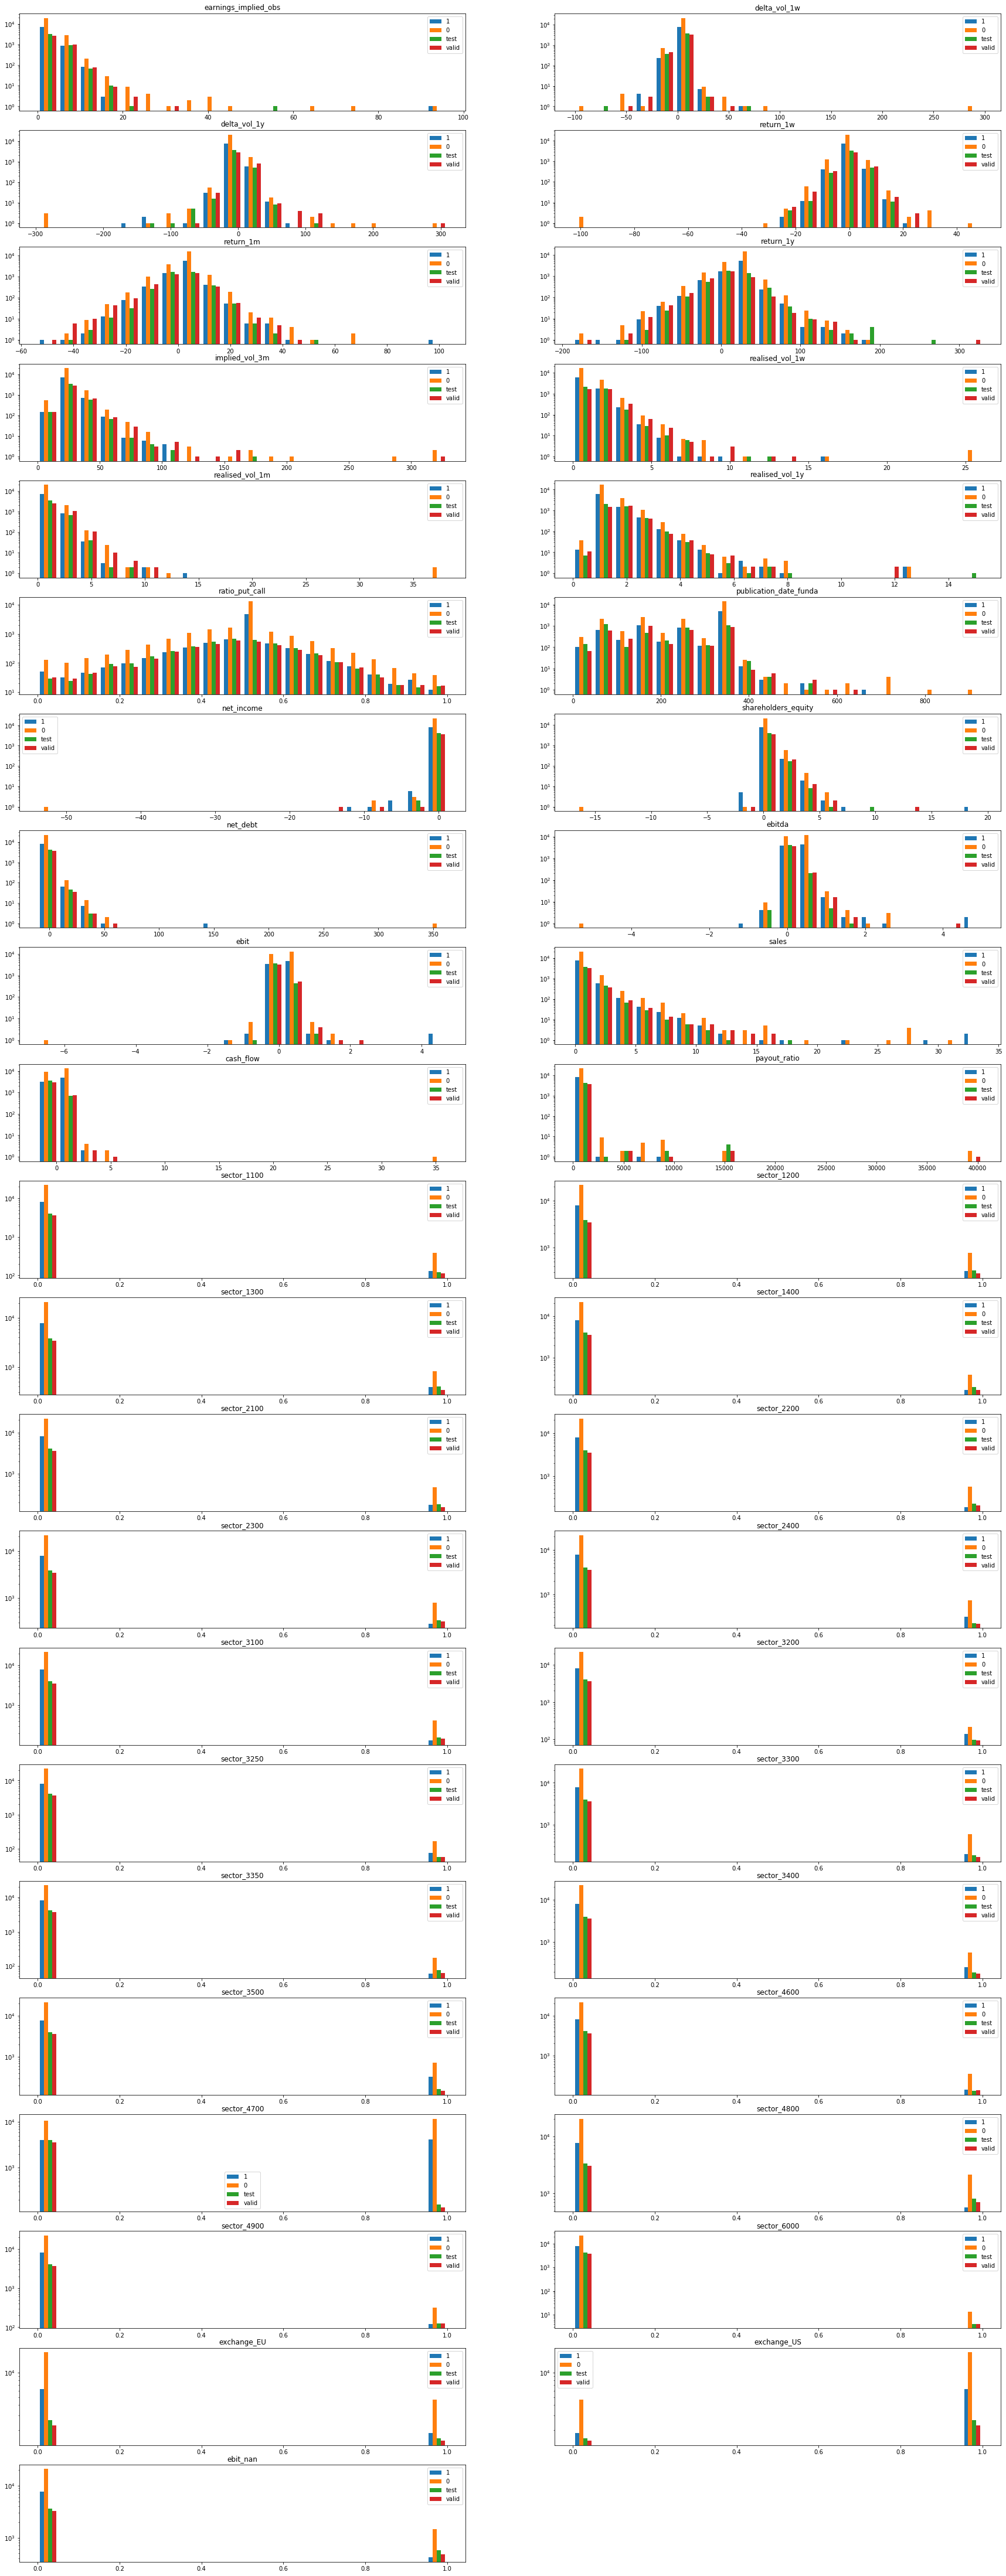

In [24]:
plt.figure(1, (30,80))
for i in np.arange(1,44):
    ax =plt.subplot(22,2,i)
    plt.title(x_train.columns[i-1])
    plot_hist(i-1, ax)

Study of the modification of the distribution of particular data

/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


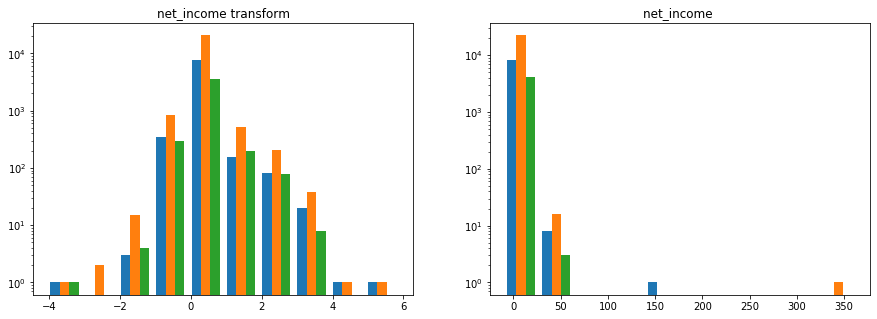

In [31]:
col=14
plt.figure(1, (15, 5))
def transfo(x):
#     return x
    return np.log(x + 1)
plt.subplot(121)
plt.hist([transfo(x_tr[true,col]).T, transfo(x_tr[false, col]).T, transfo(x_te[:,col]).T])
plt.yscale('log')
plt.title('%s transform'%X_train.columns[col])
plt.subplot(122)
plt.hist([x_tr[true,col].T, x_tr[false, col].T, x_te[:,col].T])
plt.yscale('log')
plt.title('%s '%X_train.columns[col]);

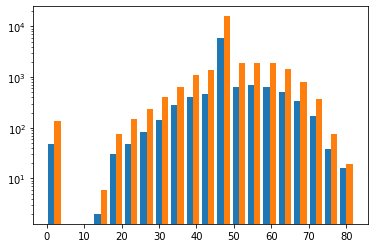

In [211]:
col=22 #earning implied obs
true = np.where(y_ph==1)
false = np.where(y_ph==0)
def transfo(x):
    return x
plt.hist([transfo(x_sh[true,col]).T, transfo(x_sh[false,col]).T], bins=20)
plt.yscale('log')

## PCA 2D

In [34]:
pca = PCA(n_components=2)
pca_res = pca.fit_transform(x_tr)
pca_sub =  pca.fit_transform(x_te)

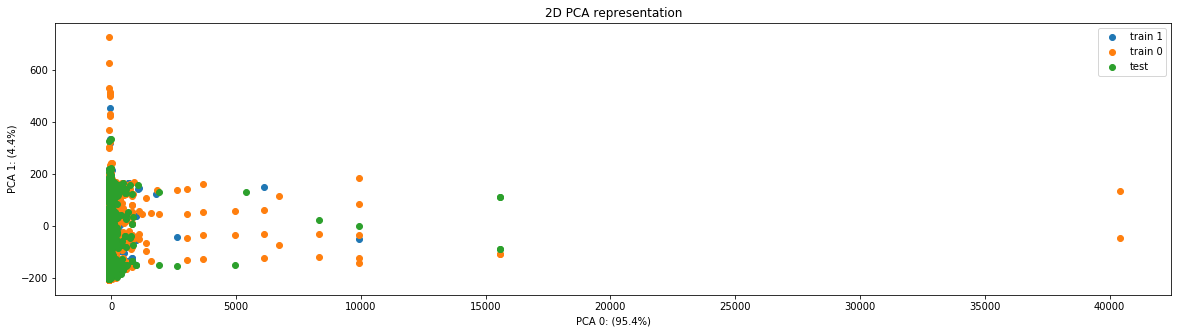

In [36]:
true = np.where(y_tr==1)
false = np.where(y_tr==0)
plt.figure(1, (20, 5))
plt.scatter(pca_res[true,0], pca_res[true,1])
plt.scatter(pca_res[false,0], pca_res[false,1])
plt.scatter(pca_sub[:,0], pca_sub[:,1])
plt.legend(['train 1', 'train 0', 'test'])
plt.xlabel('PCA 0: (%.1f%%)'% (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PCA 1: (%.1f%%)'% (pca.explained_variance_ratio_[1]*100))
plt.title('2D PCA representation');

## Correlation

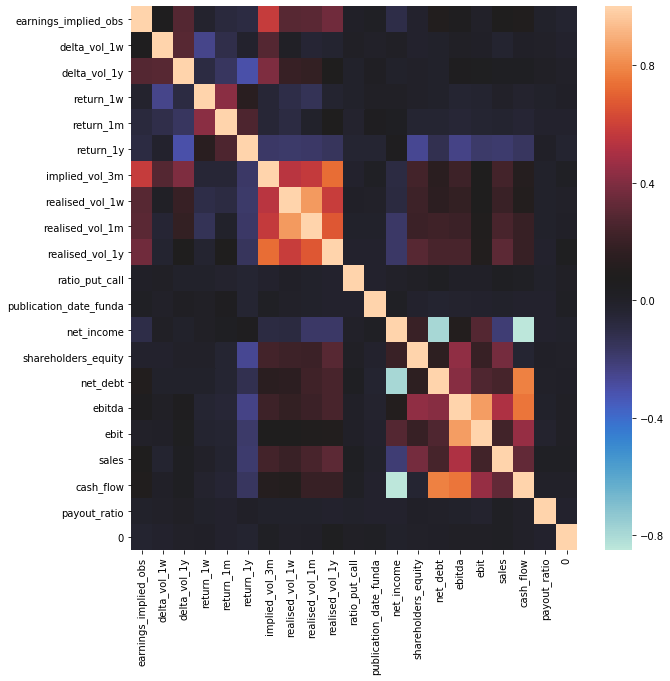

In [198]:
plt.figure(1, (10,10))
sns.heatmap(X_train.join(y_train).corr(), cmap='icefire')

# Première partie du Challenge: 19h - 11h

In [15]:
def preprocessing(X_train):
    X_train.drop(columns=['raw_id'],inplace=True) # 'sector'
    X_train.sector = X_train.sector.astype(str)
    X_train = pd.get_dummies(X_train)
    indicator = MissingIndicator(sparse=False)
    missing_id = pd.DataFrame(indicator.fit_transform(X_train[['ebit','ebitda']]), index=X_train.index, columns=['ebit_nan','ebitda_nan'])
    X_train = X_train.join(missing_id)
#     X_train['earnings_implied_obs_log'] = np.log(X_train.earnings_implied_obs +1 )
    imp = SimpleImputer(strategy='constant', fill_value='-9999')
    X_train = pd.DataFrame(imp.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_train.drop(columns=['ebit_nan','ebitda_nan', 'exchange_EU'],inplace=True) #'ebitda', 'ebit'
    return X_train

In [61]:
X_train = pd.read_csv('ref_train_x.csv')
y_train = pd.read_csv('ref_train_y.csv', header=None)
X_test = pd.read_csv('ref_test_x.csv')
X_valid = pd.read_csv('ref_valid_x.csv')

In [19]:
x_train = preprocessing(X_train)
x_test = preprocessing(X_test)
x_valid = preprocessing(X_valid)

In [20]:
x_tr = np.array(x_train.astype(float))
x_te = np.array(x_test.astype(float))
y_tr = y_train.values
x_val = np.array(x_valid.astype(float))

In [21]:
x_train

,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,sector_1100,sector_1200,sector_1300,sector_1400,sector_2100,sector_2200,sector_2300,sector_2400,sector_3100,sector_3200,sector_3250,sector_3300,sector_3350,sector_3400,sector_3500,sector_4600,sector_4700,sector_4800,sector_4900,sector_6000,exchange_US
0,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.104,17.1714,0.787627,0.884178,1.4017,0.516182,364,0.0181931,1.01175,0.924447,0.306404,0.19646,1.00036,0.245411,265.517,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,0.833054,1.37081,0.540048,66,0.0654614,0.998823,0.836746,0.280513,0.17305,0.950767,0.22552,72.3256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.95997,0.714396,0.907072,0.558759,255,0.0657108,1.00263,0.839933,0.281582,0.173709,0.954389,0.226379,72.3256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,5.485,0.3439,-0.4482,1.5906,5.501,9.4912,15.9525,0.503026,0.593907,0.877211,0.798445,358,0.0646073,0.98579,0.825828,0.276853,0.170792,0.938362,0.222578,72.3256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,2.3555,0.4032,-1.2826,1.4269,4.4619,17.4692,14.4131,0.947279,0.994358,0.876525,0.693418,62,-0.111328,0.756207,0.759751,0.252945,0.154876,0.779753,0.197967,72.3256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15244,3.209,0.7178,3.5062,-5.4471,-8.8247,29.9014,28.1854,1.60986,1.28012,1.55538,0.311784,350,0.0338288,0.160232,0.607827,0.209338,0.134406,1.27313,0.0898464,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15245,2.9008,-0.6456,-4.3162,-5.405,-1.1182,17.4631,25.0287,1.61786,1.45115,1.41199,0.592878,76,0.0375768,0.270851,0.5923,0.218764,0.142308,1.29603,0.103801,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15246,3.5993,-0.811,2.507,1.4117,3.6775,-21.2728,26.1781,0.794124,1.01104,1.71766,0.397166,77,0.0191508,0.295688,0.752754,0.282411,0.171336,1.73225,0.194061,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15247,3.3735,1.9479,4.2583,-5.2846,-13.9313,-36.3466,27.4175,1.06787,1.3036,1.85868,0.38545,169,0.0219311,0.338616,0.862038,0.32341,0.19621,1.98374,0.222235,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [27]:
auc_scorer = make_scorer(roc_auc_score)

## Random Forest

In [46]:
space={'max_depth': hp.quniform("max_depth", 3, 7, 1),
       'n_estimators' : hp.uniform("n_estimators",0.01,0.1),
        'min_samples_split' : hp.quniform('min_samples_split', 2,5,1),
        'min_samples_leaf' : hp.quniform('min_samples_leaf', 1,3,1),
        'max_features' : hp.quniform('max_features', 3, 10, 1),
        'min_impurity_decrease' : hp.quniform('min_impurity_decrease', 0, 0.4, 0.1),
        'n_estimators': 1000
    }

def hyperparameter_tuning(space):
    rand_forest=RandomForestClassifier(max_depth =space['max_depth'],
                                   n_estimators =space['n_estimators'],
                                   min_samples_split = int(space['min_samples_split']),
                                   min_samples_leaf=int(space['min_samples_leaf']), 
                                   min_impurity_decrease=space['min_impurity_decrease'], 
                                   random_state=42, 
                                   n_jobs=-1, 
                                   class_weight='balanced')
    print(rand_forest.get_params)
    rand_forest=rand_forest.fit(x_tr, y_tr.ravel())  
    
    scoring = cross_val_score(rand_forest, x_tr, y_tr.ravel(), scoring=auc_scorer, cv=5, n_jobs=-1).mean()    
    print ("SCORE:", scoring)
    
    return {'loss': -scoring, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)
print(best)

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3.0, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.2, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
SCORE:                                              
0.5                                                 
<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7.0, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrea

In [47]:
best

{'max_depth': 5.0,
 'max_features': 8.0,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3.0,
 'min_samples_split': 5.0}

In [56]:
rand_forest=RandomForestClassifier(max_depth =best['max_depth'],
                                   n_estimators =space['n_estimators'],
                                   min_samples_split = int(best['min_samples_split']),
                                   min_samples_leaf=int(best['min_samples_leaf']), 
                                   min_impurity_decrease=best['min_impurity_decrease'], 
                                   random_state=42, 
                                   n_jobs=-1, 
                                   class_weight='balanced')
rand_forest=rand_forest.fit(x_tr, y_tr.ravel())

In [59]:
scoring = cross_val_score(rand_forest, x_tr, y_tr.ravel(), scoring=auc_scorer, cv=5, n_jobs=-1)
print ("MEAN:", scoring.mean())
print ("STD:", scoring.std()) #We did not really inspect the std in the first part of the challenge

MEAN: 0.5634419902448033
STD: 0.004691165588754272


In [181]:
with open('random_forest_phase1.pkl', 'wb') as handle:
    pickle.dump(rand_forest, handle, protocol=pickle.HIGHEST_PROTOCOL)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


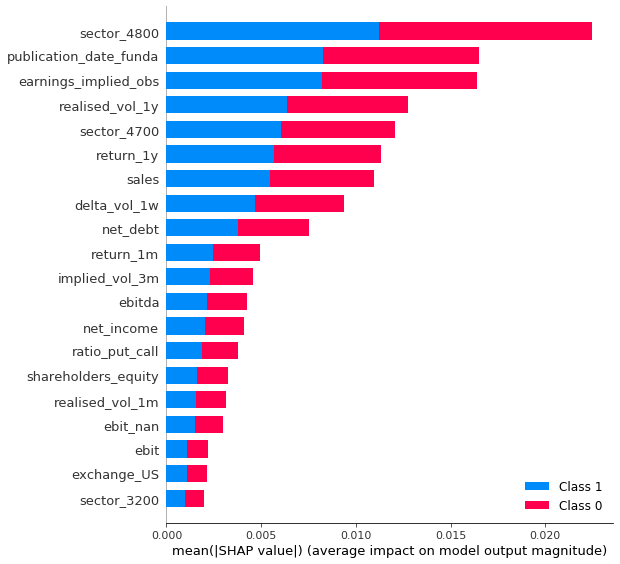

In [134]:
explainer = shap.TreeExplainer(rand_forest)
shap_values = explainer.shap_values(x_train.values)

shap.summary_plot(shap_values, x_train.values, feature_names=x_train.columns)

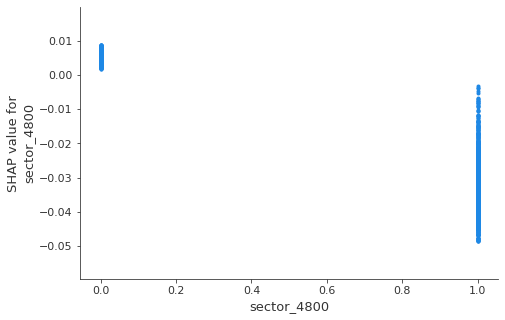

In [141]:
shap.dependence_plot("sector_4800", shap_values[1], x_train.values, feature_names=x_train.columns, interaction_index=None)

Le secteur 48 semble être négativement corrélé avec notre prédiction

## Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras

metrics = [keras.metrics.AUC(name='auc')]
nn = keras.Sequential()
nn.add(keras.layers.Dense(50, input_shape=(Xtrain_scal.shape[-1],), activation='relu'))
nn.add(keras.layers.BatchNormalization())
nn.add(keras.layers.Dropout(0.2))
nn.add(keras.layers.Dense(500, activation='relu'))
nn.add(keras.layers.BatchNormalization())
nn.add(keras.layers.Dropout(0.3))
nn.add(keras.layers.Dense(500, activation='relu'))
nn.add(keras.layers.BatchNormalization())
nn.add(keras.layers.Dropout(0.3))
nn.add(keras.layers.Dense(500, activation='relu'))
nn.add(keras.layers.BatchNormalization())
nn.add(keras.layers.Dropout(0.3))
nn.add(keras.layers.Dense(1, activation='sigmoid'))
nn.compile(
  optimizer=keras.optimizers.Adam(lr=1e-3),
  loss=keras.losses.BinaryCrossentropy(),
  metrics=metrics
)
#callback = keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=20)nn.fit(scal_test(X_train), y_train.values, epochs=42, batch_size=64, 
#callbacks=[callback], 
#validation_data=(Xval_scal, yval.values), verbose=1, class_weight={0:0.73231,1:0.26769})y_train_pred_nn = nn.predict_proba(scal_test(X_train))

## Exploration de modèles différents en vue d'un stacking 

In [ ]:
def preprocessing(X, y, imputer, imputer_strategy, fill_value=None):
    X_train = X.copy()
    y_train = y.copy()
    X_train.drop(columns=['raw_id'],inplace=True)
    X_train.sector = X_train.sector.astype(str)
    
    if imputer:
        if imputer_strategy!='mean_secteur':
            indicator = MissingIndicator(sparse=False)
            missing_id = pd.DataFrame(indicator.fit_transform(X_train[['ebit','ebitda']]), index=X_train.index, columns=['ebit_nan','ebitda_nan'])
            X_train = X_train.join(missing_id)
            imp = SimpleImputer(strategy=imputer_strategy, fill_value=fill_value)
            X_train = pd.DataFrame(imp.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
        if imputer_strategy=='mean_secteur':
            for column in np.array(X_train.isna().sum()[X_train.isna().sum()!=0].index):
                X_train[column] = X_train.groupby('sector').transform(lambda x: x.fillna(x.mean()))
    X_train = pd.get_dummies(X_train, drop_first=True)
    
    return X_train, y_train

X_train, y_train = preprocessing(X_train, y_train, True, 'mean_secteur' )

### SVM

In [ ]:
clf = SVC(gamma='auto', probability=True)
clf.fit(X_train, y_train.values.ravel())

In [1]:
y_train_pred_svc = clf.predict_proba(X_train.values)
cross_val_score(clf, X_train.values, y_train.values.ravel(), scoring=auc_scorer, cv=5, n_jobs=-1).mean()

0.5


In [ ]:
filename = 'svc.sav'
pickle.dump(clf, open(filename, 'wb'))

### ExtraTreesClassifier

In [2]:
extra_tree = ExtraTreesClassifier(n_estimators=300, random_state=0,bootstrap=True,criterion="gini", min_samples_split=5 )
extra_tree.fit(X_train, y_train.values.ravel())
cross_val_score(extra_tree, X_train.values, y_train.values.ravel(), scoring=auc_scorer, cv=5, n_jobs=-1).mean()

0.508690362347065


In [ ]:
filename = 'extra_tree.sav'
pickle.dump(clf, open(filename, 'wb'))

La performance de ces différents modèles étant trop faible, il a été décidé de ne pas explorer plus loin cette voie car il est peu probable d'avoir un gain de performance très important avec des modèles qui ne font pas mieux que l'aléatoire.

## Approche alternative

Il a également été testé d'entrainer deux modèles LGBM différents: 
- un sur les données des actions du Stoxx 600
- un sur les données des actions du SP500

In [62]:
# from data loaded in the csv
X_train['sector'] =  X_train['sector'].astype(str)
X_train = X_train.join(pd.get_dummies(X_train['sector']))
X_train.drop(columns=['sector'], inplace=True)
X_train.drop(columns=['raw_id'], inplace=True)

### Modèle exchange US

In [65]:
data_us = X_train[X_train['exchange']=="US"]
data_us.drop(columns=['exchange'], inplace=True)
y_us = y_train.iloc[data_us.index]

In [74]:
gridParams = {
             'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.001, 0.2),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [5,6,8,10,11,12,13,14, 15,16],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3,4,5]
             }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', n_jobs = 10, num_leaves = 32, scale_pos_weight= float(((y_us==0).sum() / (y_us==1).sum()).values))

grid_us = RandomizedSearchCV(mdl, gridParams,
                    verbose=1,         # Affichage des logs
                    cv=3,              # Permets de faire une validation croisée pour chaque set de paramètre
                    n_jobs=10,          # nombre de CPU à utiliser
                    scoring='roc_auc', # Ici on indique notre propre fonction de score utile pour le choix des hyperparamètres
                    n_iter=40)         # Corresponds aux nombres d'itérations donc de set de paramètre à entrainer

grid_eu = RandomizedSearchCV(mdl, gridParams,
                    verbose=1,         # Affichage des logs
                    cv=3,              # Permets de faire une validation croisée pour chaque set de paramètre
                    n_jobs=10,          # nombre de CPU à utiliser
                    scoring='roc_auc', # Ici on indique notre propre fonction de score utile pour le choix des hyperparamètres
                    n_iter=40)         # Corresponds aux nombres d'itérations donc de set de paramètre à entrainer

In [ ]:
grid_us.fit(data_us, y_us)

In [18]:
grid_us.best_params_

{'colsample_bytree': 0.6618428307478614,
 'learning_rate': 0.005365125572914308,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 508,
 'subsample': 0.7174130872709503}

In [19]:
grid_us.best_score_

0.5798161352082921

In [78]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
                         n_jobs = 10, 
                         num_leaves = 32, 
                         scale_pos_weight= float(((y_us==0).sum() / (y_us==1).sum()).values),
                         colsample_bytree= 0.6618428307478614,
                         learning_rate= 0.005365125572914308,
                         max_depth= 12,
                         min_child_weight= 5,
                         n_estimators= 508,
                         subsample= 0.7174130872709503)

In [79]:
scoring = cross_val_score(mdl, data_us, y_us, scoring=auc_scorer, cv=5, n_jobs=-1)
print ("MEAN:", scoring.mean())
print ("STD:", scoring.std())

MEAN: 0.5536841803557191
STD: 0.012596775561282081


### Modèle exchange EU

In [82]:
data_eu = X_train[X_train['exchange']=="EU"]
data_eu.drop(columns=['exchange'], inplace=True)
y_eu = y_train.iloc[data_eu.index]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
grid_eu.fit(data_eu, y_eu)

In [17]:
grid_eu.best_params_

{'colsample_bytree': 0.6341063272610662,
 'learning_rate': 0.0527821463786953,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 173,
 'subsample': 0.419766485107779}

In [16]:
grid_eu.best_score_

0.5743684697282794

In [80]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
                         n_jobs = 10, 
                         num_leaves = 32, 
                         scale_pos_weight= float(((y_us==0).sum() / (y_us==1).sum()).values),
                         colsample_bytree= 0.6341063272610662,
                         learning_rate= 0.0527821463786953,
                         max_depth= 5,
                         min_child_weight= 3,
                         n_estimators= 173,
                         subsample= 0.419766485107779)

In [83]:
scoring = cross_val_score(mdl, data_eu, y_eu, scoring=auc_scorer, cv=5, n_jobs=-1)
print ("MEAN:", scoring.mean())
print ("STD:", scoring.std())

MEAN: 0.5518629095038179
STD: 0.028575348801917283


Cette approche n'a pas été exploré plus loin faute de temps.

## Xgboost

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 6, 1),
       'learning_rate' : hp.uniform("learning_rate",0.01,0.1),
        'gamma': hp.uniform('gamma', 1,10),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'subsample' : hp.uniform('subsample', 0.8,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,0.6),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000
    }

def hyperparameter_tuning(space):
    xgb_opt=XGBClassifier(learning_rate =space['learning_rate'],
                          n_estimators =space['n_estimators'], 
                          max_depth = int(space['max_depth']), 
                          gamma = space['gamma'],
                          reg_alpha = int(space['reg_alpha']),
                          min_child_weight=space['min_child_weight'], 
                          subsample = space['subsample'],
                          colsample_bytree=space['colsample_bytree'], 
                          seed=42, 
                          n_jobs=-1, 
                          scale_pos_weight=float(((y_train==0).sum() / (y_train==1).sum()).values))
    
    scoring = cross_val_score(xgb_opt, x_tr, y_tr.ravel(), scoring=auc_scorer, cv=5, n_jobs=-1).mean()    
    print ("SCORE:", scoring)
    return {'loss': -scoring, 'status': STATUS_OK }

trials = Trials()

best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)
print(best)

In [125]:
best

{'colsample_bytree': 0.5225691715770117,
 'gamma': 4.516326586679511,
 'learning_rate': 0.018306535548870618,
 'max_depth': 4.0,
 'min_child_weight': 6.0,
 'reg_alpha': 42.0,
 'subsample': 0.8594046775124689}

In [112]:
xgb = XGBClassifier(
             learning_rate=best['learning_rate'],
             n_estimators=1000,
             min_child_weight=int(best['min_child_weight']),
             max_depth=int(best['max_depth']),
             subsample=best['subsample'],
             scale_pos_weight= float(((y_train==0).sum() / (y_train==1).sum()).values),
             colsample_bytree=best['colsample_bytree'],
             gamma=best['gamma'],
             reg_alpha=int(best['reg_alpha']),
             seed=42,
             n_jobs=-1)
xgb.fit(x_tr, y_tr.ravel(), 
        eval_set=[(x_tr, y_tr.ravel())],
        eval_metric="auc", early_stopping_rounds=30, verbose=50)

[0]	validation_0-auc:0.563408
Will train until validation_0-auc hasn't improved in 30 rounds.
[50]	validation_0-auc:0.63237
[100]	validation_0-auc:0.644323
[150]	validation_0-auc:0.652153
[200]	validation_0-auc:0.658627
[250]	validation_0-auc:0.663662
[300]	validation_0-auc:0.666733
[350]	validation_0-auc:0.671467
[400]	validation_0-auc:0.67522
[450]	validation_0-auc:0.678918
[500]	validation_0-auc:0.682077
[550]	validation_0-auc:0.68478
[600]	validation_0-auc:0.687682
[650]	validation_0-auc:0.690336
[700]	validation_0-auc:0.69249
[750]	validation_0-auc:0.694432
[800]	validation_0-auc:0.695973
[850]	validation_0-auc:0.697505
[900]	validation_0-auc:0.699227
[950]	validation_0-auc:0.700987
[999]	validation_0-auc:0.702237


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5225691715770117,
              gamma=4.516326586679511, learning_rate=0.018306535548870618,
              max_delta_step=0, max_depth=4, min_child_weight=6, missing=None,
              n_estimators=1000, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=42,
              reg_lambda=1, scale_pos_weight=2.7356687898089174, seed=42,
              silent=None, subsample=0.8594046775124689, verbosity=1)

In [113]:
scoring = cross_val_score(xgb, x_tr, y_tr.ravel(), scoring=auc_scorer, cv=5, n_jobs=-1)
print ("MEAN:", scoring.mean())
print ("STD:", scoring.std()) #We did not really inspect the std in the first part of the challenge

MEAN: 0.5674557016965314
STD: 0.007136917385097419


In [182]:
with open('xgboost_phase1.pkl', 'wb') as handle:
    pickle.dump(xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)

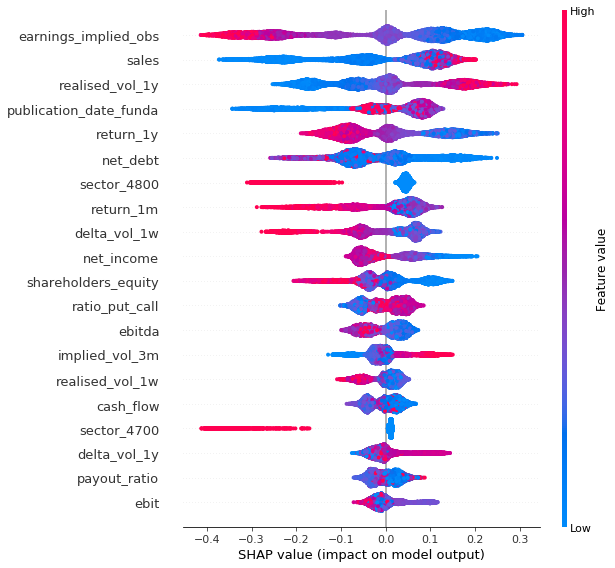

In [119]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_tr)
shap.summary_plot(shap_values, x_tr, feature_names=x_train.columns)

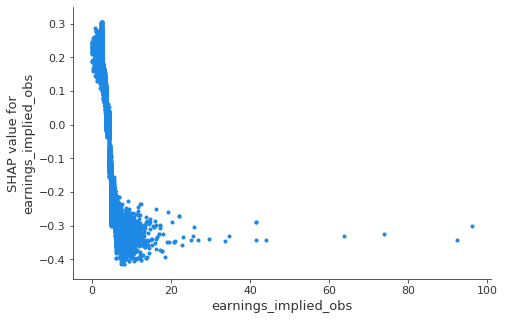

In [132]:
shap.dependence_plot("earnings_implied_obs", shap_values, x_tr, feature_names=x_train.columns, interaction_index=None)

Une petite valeur de earnings_implied_obs augmente les chances du survalorisation des prix

## Lightgbm

In [166]:
space={
    'learning_rate' : hp.uniform("learning_rate",0.01,0.1),
    'n_estimators': 1000,
    'max_depth': hp.quniform("max_depth", 3, 6, 1),
    'subsample' : hp.uniform('subsample', 0.8,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,0.6),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    }

def hyperparameter_tuning(space):
    lgb_opt=lgb.LGBMClassifier(learning_rate =space['learning_rate'],
                               n_estimators =int(space['n_estimators']), 
                               max_depth=int(space['max_depth']),
                               subsample=space['subsample'],
                               colsample_bytree=space['colsample_bytree'],
                               min_child_weight=space['min_child_weight'],
                               seed=42, 
                               n_jobs=-1,
                               scale_pos_weight=float(((y_train==0).sum() / (y_train==1).sum()).values))
    
    scoring = cross_val_score(lgb_opt, x_tr, y_tr.ravel(), scoring=auc_scorer, cv=3, n_jobs=-1).mean()    
    print ("SCORE:", scoring)
    return {'loss': -scoring, 'status': STATUS_OK }

trialslgb = Trials()

best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)
print(best)

SCORE:                                              
0.5471563009381212                                  
SCORE:                                                                        
0.5236833576027388                                                            
SCORE:                                                                        
0.5251317075856735                                                            
SCORE:                                                                        
0.5622472940362467                                                            
SCORE:                                                                        
0.541693185685567                                                             
SCORE:                                                                        
0.543700256666858                                                             
SCORE:                                                                        
0.5297475913207703       

In [167]:
best

{'colsample_bytree': 0.3898078874763161,
 'learning_rate': 0.011477683810189416,
 'max_depth': 3.0,
 'min_child_weight': 1.0,
 'subsample': 0.8671554336965592}

In [174]:
lgb_opt=lgb.LGBMClassifier(learning_rate =best['learning_rate'],
                       n_estimators =1000, 
                       max_depth=int(best['max_depth']),
                       subsample=best['subsample'],
                       colsample_bytree=best['colsample_bytree'],
                       min_child_weight=best['min_child_weight'],
                       seed=42, 
                       n_jobs=-1, 
                       scale_pos_weight=float(((y_train==0).sum() / (y_train==1).sum()).values))
lgb_opt.fit(x_tr, y_tr.ravel())

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.3898078874763161, importance_type='split',
               learning_rate=0.011477683810189416, max_depth=3,
               min_child_samples=20, min_child_weight=1.0, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=2.7356687898089174, seed=42, silent=True,
               subsample=0.8671554336965592, subsample_for_bin=200000,
               subsample_freq=0)

In [176]:
scoring = cross_val_score(lgb_opt, x_tr, y_tr.ravel(), scoring=auc_scorer, cv=5, n_jobs=-1)
print ("MEAN:", scoring.mean())
print ("STD:", scoring.std()) #We did not really inspect the std in the first part of the challenge

MEAN: 0.556267680367333
STD: 0.009827969242433612


In [183]:
with open('lightgbm_phase1.pkl', 'wb') as handle:
    pickle.dump(lgb_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


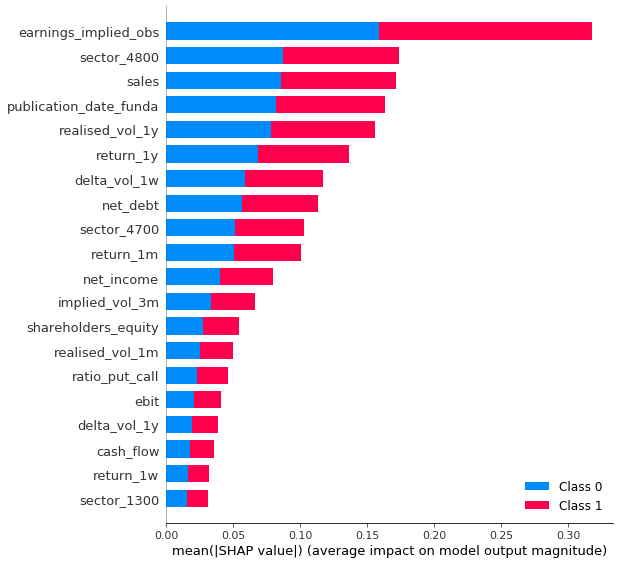

In [177]:
explainer = shap.TreeExplainer(lgb_opt)
shap_values = explainer.shap_values(x_tr)
shap.summary_plot(shap_values, x_tr, feature_names=x_train.columns)

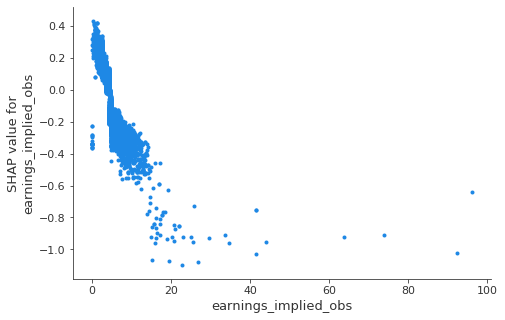

In [180]:
shap.dependence_plot("earnings_implied_obs", shap_values[1], x_tr, feature_names=x_train.columns, interaction_index=None)

## Predict File

In [125]:
np.savetxt('y_submit.csv', xgb.predict_proba(x_val)[:,1])

# Deuxième partie du challenge: 14h-19h

In [222]:
X_train = pd.read_csv('ref_phase2_train_x.csv')
y_train = pd.read_csv('ref_phase2_train_y.csv', header=None)
X_test = pd.read_csv('ref_phase2_valid_x.csv')

## Exploration des nouvelles variables

In [198]:
X_train[['score_env', 'score_soc', 'score_gov']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19440 entries, 0 to 19439
Data columns (total 3 columns):
score_env    19254 non-null float64
score_soc    19254 non-null float64
score_gov    19254 non-null float64
dtypes: float64(3)
memory usage: 455.8 KB


In [199]:
X_train[['score_env', 'score_soc', 'score_gov']].describe()

,score_env,score_soc,score_gov
count,19254.000000,19254.000000,19254.000000
mean,58.887032,58.620781,51.464068
std,12.802463,8.179286,11.337379
min,24.640000,34.420000,14.720000
25%,51.152500,52.780000,43.812500
50%,61.060000,59.130000,52.355000
75%,68.350000,64.610000,59.820000
max,90.040000,80.820000,82.110000


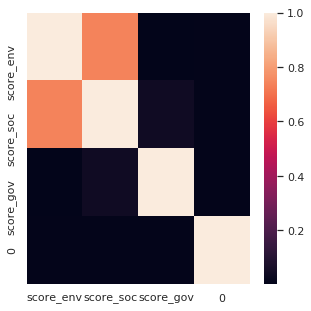

In [200]:
plt.figure(figsize=(5,5))
sns.heatmap(X_train[['score_env', 'score_soc', 'score_gov']].join(y_train).corr())

## Preprocessing

In [210]:
def preprocessing(X, y, imputer_strategy, missing_indicator, new_vars, scaling, scaling_strategy, resampling, fill_value=None):
    
    scal = MinMaxScaler()
    
    X_train = X.copy()
    y_train = y.copy()
    
    X_train.drop(columns=['raw_id'],inplace=True)
    
    X_train.sector = X_train.sector.astype(str)
    sector = X_train.sector
    
    # OHE on categorical variables ie sectors and currency
    
    X_train = pd.get_dummies(X_train, drop_first=True)
    
    # Missing indicator features for ebit and ebitda 
    
    if missing_indicator:
        indicator = MissingIndicator(sparse=False)
        missing_id = pd.DataFrame(indicator.fit_transform(X_train[['ebit','ebitda']]), index=X_train.index, columns=['ebit_nan','ebitda_nan'])
        X_train = X_train.join(missing_id)
    
    # Multiple strategies to fill missing values : knn, mean by sector, mean, median, constant, most frequent value
    
    if imputer_strategy=='knn':
        imp = KNNImputer(n_neighbors=4, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False)
        X_train = pd.DataFrame(imp.fit_transform(X_train.values), index=X_train.index, columns=X_train.columns)
        
    elif imputer_strategy=='mean_secteur':
        X_train['sector'] = sector
        X_train.sector = X_train.sector.astype(str)
        for column in np.array(X_train.isna().sum()[X_train.isna().sum()!=0].index):
            X_train[column] = X_train.groupby('sector').transform(lambda x: x.fillna(x.mean()))
        X_train.drop(columns=['sector'], inplace=True)
        
    else:
        imp = SimpleImputer(strategy=imputer_strategy, fill_value=fill_value)
        X_train = pd.DataFrame(imp.fit_transform(X_train.values), index=X_train.index, columns=X_train.columns)
     
    # New features
    
    if new_vars:
        #X_train['earnings_implied_obs_log'] = np.log(X_train.earnings_implied_obs +1)
        X_train['return_w_m'] = (X_train['return_1w'] *4 - X_train['return_1m']) / X_train['return_1w']
        X_train['realised_vol_w_m'] = (X_train['realised_vol_1w'] *4 - X_train['realised_vol_1m']) / X_train['realised_vol_1w']
        X_train['return_m_y'] = (X_train['return_1m'] * 12 - X_train['return_1y']) / X_train['return_1m']
        X_train['realised_vol_m_y'] = (X_train['realised_vol_1m'] * 12 - X_train['realised_vol_1y']) / X_train['realised_vol_1m']
    
    # Resampling with SMOTE methodology
    
    if resampling:
        smo = SMOTE(sampling_strategy='auto', 
            random_state=42, 
            k_neighbors=4, 
            n_jobs=-1)
        X_train_transfo = X_train.copy()
        y_train_transfo = y_train.copy()
        X_train, y_train = smo.fit_resample(np.array(X_train_transfo), np.array(y_train_transfo))
        X_train = pd.DataFrame(X_train, columns=X_train_transfo.columns)
        y_train = pd.DataFrame(y_train)
     
    # Scaling with min-max or with standard scaler
    
    if scaling:
        if scaling_strategy=='min_max':
            scal = MinMaxScaler()
        elif scaling_strategy=='standard':
            scal = StandardScaler()
        def scal_train(x):
            x_scal = x.copy()
            x_scal = scal.fit_transform(x_scal)
            return x_scal, scal 
        
        X_train_transfo = X_train.copy()
        X_train, scal_train = scal_train(X_train_transfo)
        X_train = pd.DataFrame(X_train, index=X_train_transfo.index, columns=X_train_transfo.columns)
        
    return X_train, y_train

## Entrainement des modèles

### XGBoost

In [172]:
# Search space for all hyperparameters, including preprocessing hyperparameters

space={
      # Model hyperparameters
    
       'max_depth': hp.quniform("max_depth", 3, 6, 1),
       'learning_rate' : hp.uniform("learning_rate",0.01,0.1),
        'gamma': hp.uniform('gamma', 1,10),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'subsample' : hp.uniform('subsample', 0.8,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,0.6),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'scale_pos_weight': hp.choice('scale_pos_weight',[None, float(((y_train==0).sum() / (y_train==1).sum()).values)]),
        'n_estimators': hp.quniform('n_estimators', 100, 1000,100),
       
       # Preprocessing hyperparameters
       
        'imputer_strategy': hp.choice('imputer_strategy', ['mean_secteur', 'mean', 'median', 'most_frequent', 'constant','knn']),
        'missing_indicator': hp.choice('missing_indicator',[True,False]),
        'new_vars':hp.choice('new_vars',[True,False]),
        'scaling':hp.choice('scaling',[True,False]),
        'scaling_strategy':hp.choice('scaling_strategy', ['min_max','standard']),
        'resampling':hp.choice('resampling', [False]),
        'fill_value': hp.choice('fill_value',[-9999,-999,0,999,9999])
    }

# Training the model on cross-validation folds and compute a score for model selection

def hyperparameter_tuning(space):
    Xtrain, ytrain = preprocessing(X_train, y_train,  
                       imputer_strategy=space['imputer_strategy'], 
                       missing_indicator=space['missing_indicator'], 
                       new_vars=space['new_vars'],
                       scaling=space['scaling'],
                       scaling_strategy=space['scaling_strategy'], 
                       resampling=space['resampling'], 
                       fill_value=space['fill_value'])  

    # If X is oversampled, then we don't use the scale_pos_weight parameter
    
    if not space["resampling"] :
    
        xgb_opt=XGBClassifier(learning_rate =space['learning_rate'],
                              n_estimators =int(space['n_estimators']), 
                              max_depth = int(space['max_depth']), 
                              gamma = space['gamma'],
                              reg_alpha = int(space['reg_alpha']),
                              min_child_weight=space['min_child_weight'], 
                              subsample = space['subsample'],
                              colsample_bytree=space['colsample_bytree'], 
                              seed=42, 
                              n_jobs=-1, 
                              scale_pos_weight=space['scale_pos_weight'])
        
    else:

        xgb_opt=XGBClassifier(learning_rate =space['learning_rate'],
                              n_estimators =int(space['n_estimators']), 
                              max_depth = int(space['max_depth']), 
                              gamma = space['gamma'],
                              reg_alpha = int(space['reg_alpha']),
                              min_child_weight=space['min_child_weight'], 
                              subsample = space['subsample'],
                              colsample_bytree=space['colsample_bytree'], 
                              seed=42, 
                              n_jobs=-1)        

    #print(space)
    
    cv_scoring = cross_val_score(xgb_opt, Xtrain.values, ytrain.values.ravel(), scoring=auc_scorer, cv=8, n_jobs=-1)
    scoring_mean = cv_scoring.mean()
    scoring_std = cv_scoring.std()
    
    if scoring_std>=0.1:
        scoring = 0
    else:
        scoring = scoring_mean / max(0.01, scoring_std)
    
    print ("SCORE Mean:", scoring_mean)
    print ("SCORE Std:", scoring_std)
    return {'loss': -scoring, 'status': STATUS_OK }

# Launch the research 

trials = Trials()
best_xgb = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print(best_xgb)

SCORE Mean:                                           
0.5522610444453961                                    
SCORE Std:                                            
0.005996525554703017                                  
SCORE Mean:                                                                      
0.5564235228154855                                                               
SCORE Std:                                                                       
0.010418186214796817                                                             
SCORE Mean:                                                                      
0.53887182278588                                                                 
SCORE Std:                                                                       
0.009181221397274394                                                             
SCORE Mean:                                                                      
0.5                                       

### LGBM

In [173]:
# Search space for all hyperparameters, including preprocessing hyperparameters

space={
        # Model hyperparameters
    
        'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart','goss']),
        'num_leaves': hp.quniform('num_leaves', 8, 100, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
        'feature_fraction': hp.uniform('feature_fraction', 0.3, 0.6),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.8, 1), #alias "subsample"
        'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'lambda_l1':  hp.loguniform('lambda_l1', -16, 2),
        'lambda_l2':  hp.loguniform('lambda_l2', -16, 2),
       'min_child_weight': hp.loguniform('min_child_weight', -16, 5),
       'scale_pos_weight': hp.choice('scale_pos_weight',[None, float(((y_train==0).sum() / (y_train==1).sum()).values)]),
       'n_estimators': hp.quniform('n_estimators', 100, 1000,100),
    
        # Preprocessing hyperparameters
    
       'fill_value': hp.choice('fill_value',[-9999,-999,0,999,9999]),
       "imputer_strategy" : hp.choice("imputer_strategy", ['mean_secteur', 'mean', 'median', 'most_frequent', 'constant','knn']),
       "new_vars" : hp.choice("new_vars", [True, False]),
       "scaling" : hp.choice("scaling",[True, False]),
       "scaling_strategy" : hp.choice("scaling_strategy",["min_max", "standard"]),
       "resampling": hp.choice("resampling", [True, False]),
        'missing_indicator': hp.choice('missing_indicator',[True,False]),
    }

# Training the model on cross-validation folds and compute a score for model selection

def hyperparameter_tuning(space):
    Xtrain, ytrain = preprocessing(X_train, y_train, space["imputer_strategy"],space["missing_indicator"],
                                   space["new_vars"], space["scaling"], space["scaling_strategy"] , 
                                  space["resampling"],space['fill_value'])
    
    # If X is oversampled, then we don't use the scale_pos_weight parameter
    
    if not space["resampling"] : 
        lgb_opt=lgb.LGBMClassifier(learning_rate =space['learning_rate'],
                                   n_estimators =int(space['n_estimators']), 
                                   min_child_weight=int(space['min_child_weight']), 
                                   lambda_l2 = space['lambda_l2'],
                                   lambda_l1=space['lambda_l1'], 
                                   seed=42, 
                                   n_jobs=-1, 
                                   silent = True,
                                   min_data_in_leaf=int(space['min_data_in_leaf']), 
                                   bagging_fraction=space['bagging_fraction'],
                                   feature_fraction=space['feature_fraction'],
                                   subsample_for_bin=int(space['subsample_for_bin']),
                                   num_leaves=int(space['num_leaves']) ,
                                   boosting_type=space['boosting_type'],
                                   scale_pos_weight=space['scale_pos_weight'])
    else : 
         lgb_opt=lgb.LGBMClassifier(learning_rate =space['learning_rate'],
                                    n_estimators =int(space['n_estimators']), 
                                    min_child_weight=int(space['min_child_weight']), 
                                    lambda_l2 = space['lambda_l2'],
                                    lambda_l1=space['lambda_l1'], 
                                    seed=42, 
                                    n_jobs=-1, 
                                    silent = True,
                                    min_data_in_leaf=int(space['min_data_in_leaf']), 
                                    bagging_fraction=space['bagging_fraction'],
                                    feature_fraction=space['feature_fraction'],
                                    subsample_for_bin=int(space['subsample_for_bin']),
                                    num_leaves=int(space['num_leaves']) ,
                                    boosting_type=space['boosting_type'])
    #print(space)

    cv_scoring = cross_val_score(lgb_opt, Xtrain.values, ytrain.values.ravel(), scoring=auc_scorer, cv=10, n_jobs=-1)
    scoring_mean = cv_scoring.mean()
    scoring_std = cv_scoring.std()
    
    if scoring_std>=0.1:
        scoring = 0
    else:
        scoring = scoring_mean / max(0.01, scoring_std)
    print ("SCORE Mean:", scoring_mean)
    print ("SCORE Std:", scoring_std)
    return {'loss': -scoring, 'status': STATUS_OK }

# Launch the research 

trials = Trials()
best_lgbm = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print(best_lgbm)

SCORE Mean:                                           
0.5363799207501987                                    
SCORE Std:                                            
0.012503006790419414                                  
SCORE Mean:                                                                      
0.5282508987113622                                                               
SCORE Std:                                                                       
0.012829187372705275                                                             
SCORE Mean:                                                                      
0.6456228730250223                                                               
SCORE Std:                                                                       
0.0741098667831668                                                               
SCORE Mean:                                                                      
0.49995567973306787                       

## Train Best model

In [231]:
def train_best_model (best, X_train, y_train, model) :
    
    # Preprocessing with the best hyperparameters
    
    Xtrain, ytrain = preprocessing(X_train, y_train, ['mean_secteur', 'mean', 'median', 'most_frequent', 'constant','knn'][best["imputer_strategy"]],
                        [True, False][int(best["missing_indicator"])],
                        [True, False][int(best["new_vars"])],
                        [True, False][int(best["scaling"])],
                        ["min_max", "standard"][int(best["scaling_strategy"])],
                        [True, False][int(best["resampling"])],
                        [-9999,-999,0,999,9999] [int(best["fill_value"])])
    
    # Training with the best hyperparameters
    
    if model=='lgbm':
        best_model = lgb.LGBMClassifier(learning_rate =best['learning_rate'],
                           n_estimators =int(best['n_estimators']),
                           min_child_weight=int(best['min_child_weight']),
                           lambda_l2 = best['lambda_l2'],
                           lambda_l1=best['lambda_l1'],
                           seed=42,
                           n_jobs=-1,
                           silent = True,
                           min_data_in_leaf=int(best['min_data_in_leaf']),
                           bagging_fraction=best['bagging_fraction'],
                           feature_fraction=best['feature_fraction'],
                           subsample_for_bin=int(best['subsample_for_bin']),
                           num_leaves=int(best['num_leaves']),
                           boosting_type=['gbdt', 'dart','goss'][best['boosting_type']],
                           scale_pos_weight=[None, float(((y_train==0).sum() / (y_train==1).sum()).values)][best['scale_pos_weight']]).fit(Xtrain, ytrain)
        
    elif model=='xgb':
        best_model = XGBClassifier(learning_rate =best['learning_rate'],
                                   n_estimators =int(best['n_estimators']), 
                                   max_depth = int(best['max_depth']), 
                                   gamma = best['gamma'],
                                   reg_alpha = best['reg_alpha'],
                                   min_child_weight=best['min_child_weight'], 
                                   subsample = best['subsample'],
                                   colsample_bytree=best['colsample_bytree'], 
                                   seed=42, 
                                   n_jobs=-1, 
                                   scale_pos_weight=[None, float(((y_train==0).sum() / (y_train==1).sum()).values)][best['scale_pos_weight']]).fit(Xtrain, ytrain)

    return best_model, Xtrain, ytrain

### XGBoost

In [235]:
best_xgb = {'colsample_bytree': 0.3141677767723539,
 'fill_value': 1,
 'gamma': 4.873658001250899,
 'imputer_strategy': 3,
 'learning_rate': 0.0438539970399488,
 'max_depth': 3.0,
 'min_child_weight': 8.0,
 'missing_indicator': 1,
 'n_estimators': 300.0,
 'new_vars': 1,
 'reg_alpha': 15.0,
 'resampling': 0,
 'scale_pos_weight': 1,
 'scaling': 1,
 'scaling_strategy': 0,
 'subsample': 0.8171358283672567}

In [236]:
best_model_xgb, Xtrain_xgb, ytrain_xgb = train_best_model(best_xgb, X_train, y_train, 'xgb')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [238]:
scoring = cross_val_score(best_model_xgb, Xtrain.values, ytrain.values.ravel(), scoring=auc_scorer, cv=5, n_jobs=-1)
print ("MEAN:", scoring.mean())
print ("STD:", scoring.std()) 

MEAN: 0.561068129474996
STD: 0.0023552168405366644


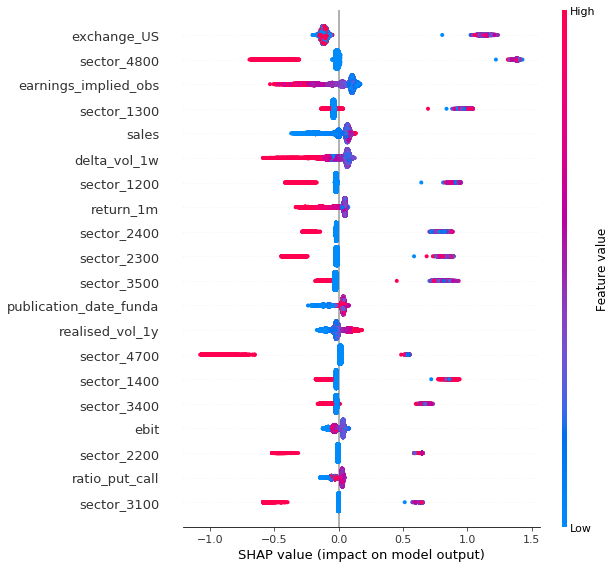

In [247]:
explainer = shap.TreeExplainer(best_model_xgb)
shap_values = explainer.shap_values(Xtrain_xgb.values)
shap.summary_plot(shap_values, Xtrain_xgb.values, feature_names=Xtrain_xgb.columns)

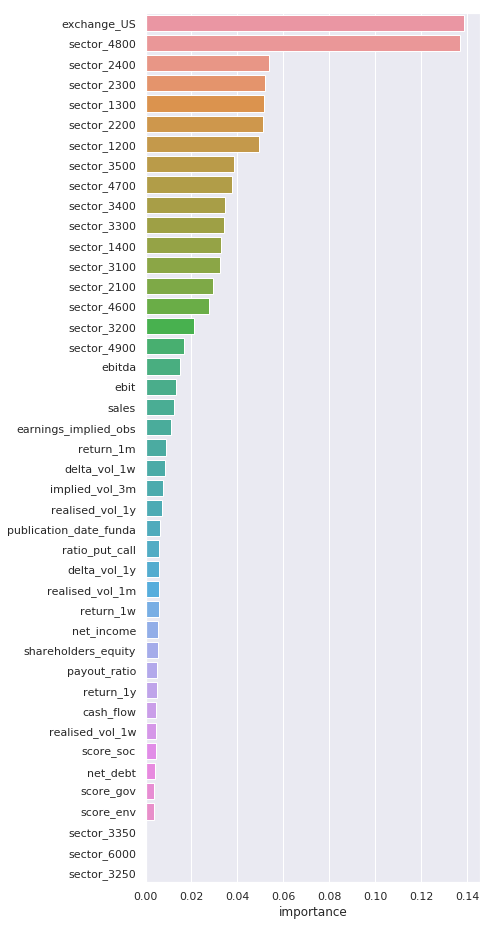

In [183]:
# Plot features importance 

plt.figure(figsize=(6,16))

xgb_feature_importances = pd.DataFrame(best_model_xgb.feature_importances_,
                                   index = Xtrain_xgb.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

sns.barplot(data=xgb_feature_importances, x='importance', y=xgb_feature_importances.index)

### LGBM

In [229]:
best_lgbm ={'bagging_fraction': 0.9032937911772275,
 'boosting_type': 0,
 'feature_fraction': 0.5723304263259852,
 'fill_value': 0,
 'imputer_strategy': 5,
 'lambda_l1': 0.00022002721491807284,
 'lambda_l2': 0.005073858033888252,
 'learning_rate': 0.06670767931684303,
 'min_child_weight': 1.8922364899366209,
 'min_data_in_leaf': 51.0,
 'missing_indicator': 0,
 'n_estimators': 200.0,
 'new_vars': 1,
 'num_leaves': 26.0,
 'resampling': 1,
 'scale_pos_weight': 1,
 'scaling': 0,
 'scaling_strategy': 0,
 'subsample_for_bin': 100000.0}

In [232]:
lgbm_opt_best, Xtrain, ytrain = train_best_model (best_lgbm, X_train, y_train, 'lgbm')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [233]:
scoring = cross_val_score(lgbm_opt_best, Xtrain.values, ytrain.values.ravel(), scoring=auc_scorer, cv=5, n_jobs=-1)
print ("MEAN:", scoring.mean())
print ("STD:", scoring.std()) 

MEAN: 0.5497979445862304
STD: 0.006875495029649301


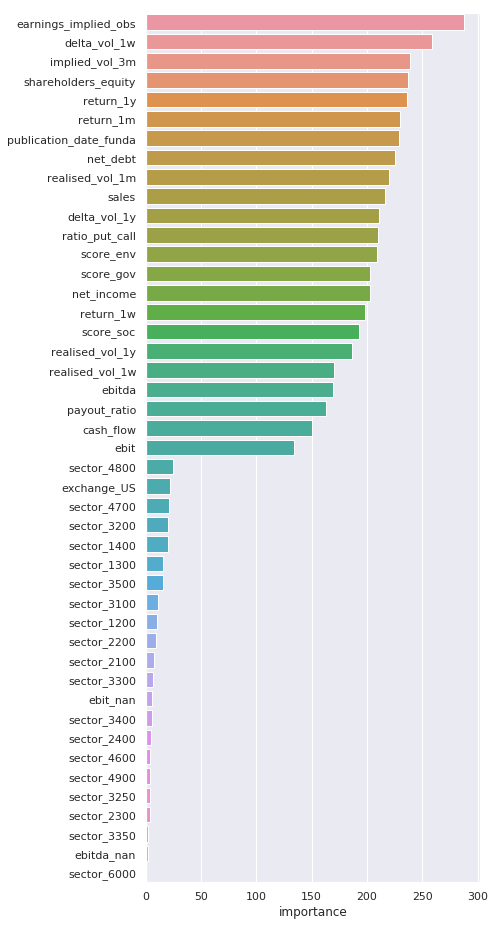

In [186]:
# Plot features importance 

plt.figure(figsize=(6,16))

lgbm_feature_importances = pd.DataFrame(best_model_lgbm.feature_importances_,
                                   index = Xtrain_lgbm.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

sns.barplot(data=lgbm_feature_importances, x='importance', y=lgbm_feature_importances.index)

## Save and submit

In [188]:
# Save the classifiers

with open('xgb.pkl', 'wb') as f:
    pickle.dump(best_model_xgb, f)  
    
with open('lgbm.pkl', 'wb') as f:
    pickle.dump(best_model_lgbm, f)  

In [196]:
best_model = best_model_lgbm
#best_model = best_model_xgb

best = best_lgbm
#best = best_xgb

Xtest_lgbm, _ = preprocessing(X_test, y_train, ['mean_secteur', 'mean', 'median', 'most_frequent', 'constant','knn'][best["imputer_strategy"]],
                        [True, False][int(best["missing_indicator"])],
                        [True, False][int(best["new_vars"])],
                        [True, False][int(best["scaling"])],
                        ["min_max", "standard"][int(best["scaling_strategy"])],
                        False,
                        [-9999,-999,0,999,9999] [int(best["fill_value"])])

np.savetxt('y_submit.csv', best_model.predict_proba(Xtest_lgbm)[:,1])